# PyTorch Basics

I'll assume that everyone is familiar with python. Training neural nets in bare python is somewhat painful, but fortunately there are several well-established libraries which can help. I like pytorch, which is built upon an earlier library called torch. There are many others, including TensorFlow and Jax.

In [1]:
# We start by importing the libraries we'll use today
import numpy as np
import torch
import torchvision

In [2]:
a = np.random.rand(2,3)
b = torch.from_numpy(a)

print(a)
print(b)

[[0.03762737 0.61531328 0.96379353]
 [0.44333666 0.53074609 0.18754791]]
tensor([[0.0376, 0.6153, 0.9638],
        [0.4433, 0.5307, 0.1875]], dtype=torch.float64)


In [3]:
print(b + 10.0)
print()
print(torch.sin(b))
print()
print(b.sum())
print()
print(b.mean())
print()
print(b.shape)

tensor([[10.0376, 10.6153, 10.9638],
        [10.4433, 10.5307, 10.1875]], dtype=torch.float64)

tensor([[0.0376, 0.5772, 0.8214],
        [0.4290, 0.5062, 0.1865]], dtype=torch.float64)

tensor(2.7784, dtype=torch.float64)

tensor(0.4631, dtype=torch.float64)

torch.Size([2, 3])


Torch believes everything is a *tensor.*

The main intuition is that tensors allow for intuitive and efficient matrix multiplication across different indexing dimensions. Soon, we will see that training neural nets basically consits of *forward* and *backward* passes, both of which are essentially matrix multiplies.

The other thing about torch variables is that they (natively) can be differentiated. Again, we'll see why this is important when we learn about backpropagation.

Suppose we want $dy/da$ in the following expression:
- $y = a + b$

In [4]:
a = torch.rand(1,1, requires_grad=True)
b = torch.rand(1,1)
y = a + b
print("a:", a)
print("b:", b)
print("y:", y)

a: tensor([[0.1557]], requires_grad=True)
b: tensor([[0.9482]])
y: tensor([[1.1039]], grad_fn=<AddBackward0>)


Here, $y$ is a function of the input $a$ so we can use PyTorch to compute $dy/da$

In [5]:
y.backward()
print("dy/da:", a.grad)

dy/da: tensor([[1.]])


Let's try this again with a more complex function:
- $y = a^2 \cdot b$



In [6]:
a = torch.rand(1,1, requires_grad=True)
b = torch.rand(1,1)
y = (a**2)*b
print("a:", a)
print("b:", b)
print("y:", y)
y.backward()
print("dy/da:", a.grad)
print("dy/da:", 2 * a * b)

a: tensor([[0.3580]], requires_grad=True)
b: tensor([[0.8442]])
y: tensor([[0.1082]], grad_fn=<MulBackward0>)
dy/da: tensor([[0.6045]])
dy/da: tensor([[0.6045]], grad_fn=<MulBackward0>)


Torch has calculated $dy/da$ using backpropagation which is in agreement with our answer calculated using standard differentiation rules.

Here is an example with matrices and vectors:

In [7]:
A = torch.rand(2,2)
b = torch.rand(2,1)
x = torch.rand(2,1, requires_grad = True)

y = torch.matmul(A, x) + b
z = y.sum()

Here, $z$ is a function of the input $x$. Let us now compute the derivative of $z$ with respect to $x$ using backpropagation.

In [8]:
z.backward()
print(x)
print(x.grad)

tensor([[0.4047],
        [0.2569]], requires_grad=True)
tensor([[1.2024],
        [1.1582]])


## Training simple models

Let's jump in with our first, simple model. We will train a logistic classifier (equivalent to using a single-layer neural network) on a popular image dataset called *Fashion-MNIST*. Torchvision also has several other image datasets which we can directly load as variables.

In [9]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())


100%|██████████| 26.4M/26.4M [00:02<00:00, 10.9MB/s]


Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 169kB/s]


Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.21MB/s]


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 10.8MB/s]

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



Let's check that everything has been downloaded.

In [10]:
print(len(trainingdata))
print(len(testdata))

60000
10000


Let's investigate to see what's inside the dataset.

In [11]:
image, label = trainingdata[0]
print(image.shape, label)

torch.Size([1, 28, 28]) 9


We cannot directly plot the image object given that its first dimension has a size of 1. So we will use the `squeeze` function to get rid of the first dimension.

In [12]:
print(image.squeeze().shape)

torch.Size([28, 28])


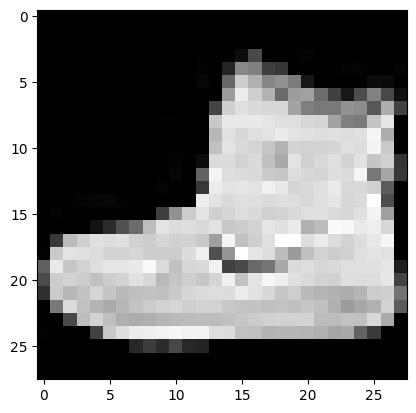

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(image.squeeze(), cmap=plt.cm.gray)

Looks like a shoe? Fashion-MNIST is a bunch of different black and white images of clothing with a corresponding label identifying the category the clothing belongs to. It looks like label 9 corresponds to shoes.

In order to nicely wrap the process of iterating through the dataset, we'll use a dataloader.

In [14]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=64,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64,shuffle=False)

Let's also check the length of the train and test dataloader

In [15]:
print(len(trainDataLoader))
print(len(testDataLoader))

938
157


The length here depends upon the batch size defined above. Multiplying the length of our dataloader by the batch size should give us back the number of samples in each set.

In [16]:
print(len(trainDataLoader) * 64) # batch_size from above
print(len(testDataLoader) * 64)

60032
10048


Now let's use it to look at a few images.

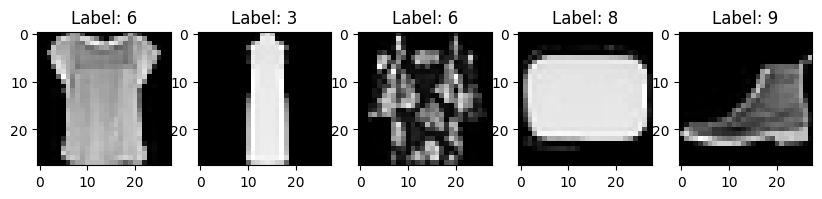

In [17]:
images, labels = next(iter(trainDataLoader))

plt.figure(figsize=(10,4))
for index in np.arange(0,5):
  plt.subplot(1,5,index+1)
  plt.title(f'Label: {labels[index].item()}')
  plt.imshow(images[index].squeeze(),cmap=plt.cm.gray)

Now let's set up our model.

In [ ]:
class LinearReg(torch.nn.Module):
  def __init__(self):
    super(LinearReg, self).__init__()
    self.linear = torch.nn.Linear(28*28, 10)

  def forward(self, x):
    x = x.view(-1, 28*28) # change so 784 vector instead of 28x28 matrix
    return self.linear(x)

model = LinearReg().cuda() # Step 1: architecture
loss = torch.nn.CrossEntropyLoss() # Step 2: loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Step 3: training method

In [ ]:
# Now set up a dense neural network with 3 hidden layers
class DenseNeuralNetwork(torch.nn.Module):
  def __init__(self):
    super(DenseNeuralNetwork, self).__init__()

    # Layer 1
    self.layer1 = torch.nn.Linear(28*28, 512)
    self.layer

Now let's train our model!

In [ ]:
train_loss_history = []
test_loss_history = []
i
for epoch in range(20):
  train_loss = 0.0
  test_loss = 0.0

  model.train()
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad() # zero out any gradient values from the previous iteration
    predicted_output = model(images) # forward propagation
    fit = loss(predicted_output, labels)  # calculate our measure of goodness
    fit.backward() # backpropagation
    optimizer.step() # update the weights of our trainable parameters
    train_loss += fit.item()

  model.eval()
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      predicted_output = model(images)
      fit = loss(predicted_output, labels)
      test_loss += fit.item()
  train_loss = train_loss / len(trainDataLoader)
  test_loss = test_loss / len(testDataLoader)
  train_loss_history += [train_loss]
  test_loss_history += [test_loss]
  print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}')

Epoch 0, Train loss 0.9645802863498232, Test loss 0.7385323450064204
Epoch 1, Train loss 0.6690339967131869, Test loss 0.6463313846831109
Epoch 2, Train loss 0.6039779036284001, Test loss 0.6058223076686737
Epoch 3, Train loss 0.5688773199502848, Test loss 0.5776552434559841
Epoch 4, Train loss 0.5461299240207875, Test loss 0.5591050097896795
Epoch 5, Train loss 0.5293311565669615, Test loss 0.5461011320162731
Epoch 6, Train loss 0.5165531993039382, Test loss 0.5383210007552128
Epoch 7, Train loss 0.5059611464518983, Test loss 0.5292828232999061
Epoch 8, Train loss 0.4977643424386917, Test loss 0.5212589265054958
Epoch 9, Train loss 0.4908087180812222, Test loss 0.5189674432110635
Epoch 10, Train loss 0.4845370182128095, Test loss 0.5106574076755791
Epoch 11, Train loss 0.47917497021430083, Test loss 0.5050833236639667
Epoch 12, Train loss 0.47441845080618666, Test loss 0.5008792759506566
Epoch 13, Train loss 0.4703543161087707, Test loss 0.4994942868591114
Epoch 14, Train loss 0.46619

Let's plot our loss by training epoch to see how we did.

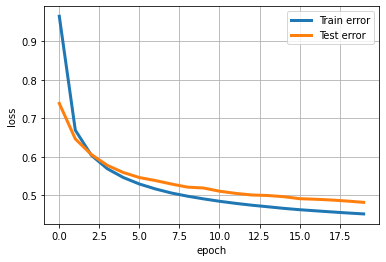

In [ ]:
plt.plot(range(20),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(20),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

Why is test loss larger than training loss?

We definitely see some improvement. Let's look at the images, the predictions our model makes and the true label.

Now for the labels and predicted labels.

In [ ]:
predicted_outputs = model(images)
predicted_classes = torch.max(predicted_outputs, 1)[1]
print('Predicted:', predicted_classes)
fit = loss(predicted_output, labels)
print('True labels:', labels)
print(fit.item())

Predicted: tensor([3, 1, 7, 5, 8, 2, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0')
True labels: tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0')
0.32213398814201355


Text(0.5, 1.0, 'Pred: 1, True: 2')

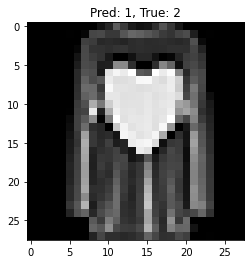

In [ ]:
plt.imshow(images[1].squeeze().cpu(), cmap=plt.cm.gray)
plt.title(f'Pred: {predicted_classes[1].item()}, True: {labels[1].item()}')